# Módulo 4 - Projeto 1: *support vector machines*

Professora: Esther Colombini -- esther@ic.unicamp.br

Monitores: Alana Santana -- alana.correia@ic.unicamp.br
           Hudson Bruno -- hudson.bruno@ic.unicamp.br

Este *notebook* faz parte da disciplina INF-0616 no curso de extensão MDC.  
Demais artefatos podem ser encontrados no moodle da disciplina: 
[moodle.lab.ic.unicamp.br/456](https://moodle.lab.ic.unicamp.br/moodle/course/view.php?id=456)

Instituto de Computação - Unicamp 2021

In [149]:
from __future__ import print_function

from math import ceil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm

import seaborn as sns

from IPython.display import display

In [2]:
np.random.seed(1082141)
sns.set()

## Classificando imagens de dígitos
### Lendo o conjunto de dados

**Pen-Based Recognition of Handwritten Digits Data Set**
é um banco de imagens simples e bem conhecido em reconhecimento de imagens.  
Ele é composto por imagens em escala cinza de 8 por 8 pixels divididas em 10 classes de dígitos.

Uma descrição completa pode ser encontrada no seguinte link: [archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits](http://archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits)

In [35]:
x, y = datasets.load_digits(return_X_y=True)

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=.5,
                                                    random_state=42)
print('amostras em treino: %i' % x_train.shape[0],
      'amostras em teste: %i' % x_test.shape[0],
      'número de características: %i' % x_train.shape[1],
      'número de classes: %i' % (np.max(y_train) + 1),
      sep='\n', end='\n\n')

amostras em treino: 898
amostras em teste: 899
número de características: 64
número de classes: 10



### 64 primeiras amostras no conjunto de treinamento

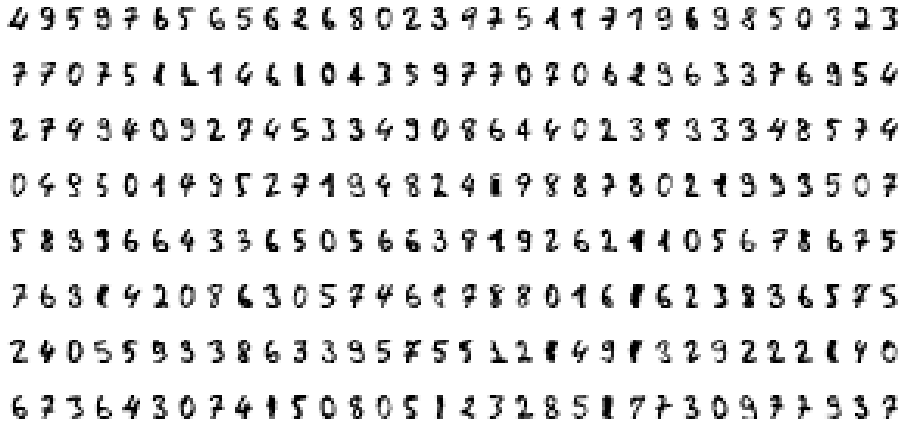

In [36]:
plt.figure(figsize=(16, 8))

for ix in range(8  * 32):
    plt.subplot(8, 32, ix + 1)
    plt.imshow(x_train[ix].reshape(8, 8), cmap='Greys')
    plt.axis('off')

### Visualizando o conjunto e frequências das classes

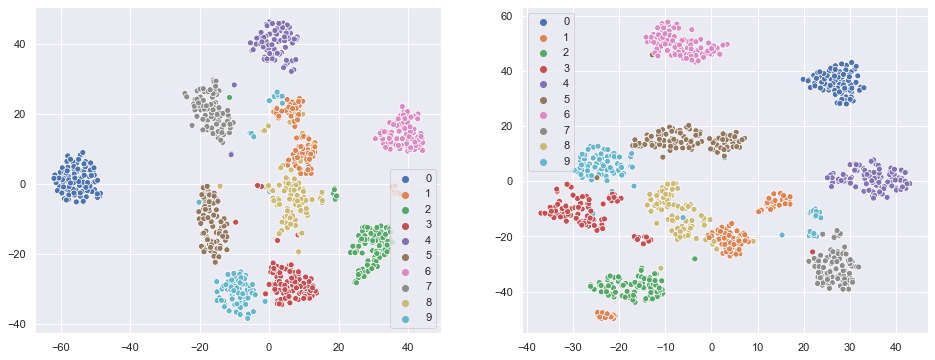

In [37]:
from sklearn.manifold import TSNE

encoder2D = TSNE()
w_train = encoder2D.fit_transform(x_train)
w_test = encoder2D.fit_transform(x_test)

plt.figure(figsize=(16, 6))
categorical_colors = sns.color_palette()

for ix, (x, y) in enumerate(((w_train, y_train), (w_test, y_test))):
    plt.subplot(1, 2, ix + 1)
    sns.scatterplot(*x.T, hue=y, palette=categorical_colors);

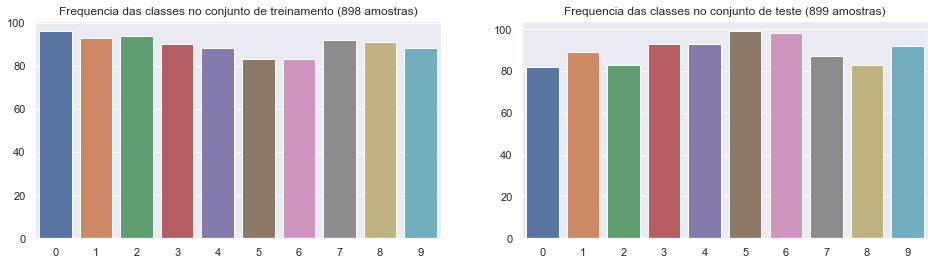

In [38]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.title('Frequencia das classes no conjunto de treinamento (%i amostras)' % len(x_train))
labels, counts = np.unique(y_train, return_counts=True)
sns.barplot(labels, counts)

plt.subplot(122)
plt.title('Frequencia das classes no conjunto de teste (%i amostras)' % len(x_test))
labels, counts = np.unique(y_test, return_counts=True)
sns.barplot(labels, counts);

### Modelando um classificador de digitos

**Atividade (3 pts):** defina e treine uma máquina de vetor de suporte com diferentes tipos de kernel, utilizando o scikit-learn. Avalie os diversos tipos de kernel e seus respectivos parâmetros com relação a qualidade da solução. Você deve separar uma parte do conjunto de treino para fazer a validação cruzada. Não utilize o conjunto de teste ainda.

In [69]:
# Definindo variaveis
# Random State
rs = 42

# Conjunto de treino
x = x_train
y = y_train

# Conjunto completo apenas para extrair todas as labels de classificacao
digits = datasets.load_digits()

In [117]:
# Funcoes Auxiliares

# Deve-se passar uma Confusion Matrix relativa para a funcao
def acuracia_balanceada(confusion_matrix) -> float:
    size = c.shape[1]
    acc_acum = 0

    for i in range(size):
        acc_acum += confusion_matrix[i][i]
        
    acc_acum = acc_acum/(size)

    return acc_acum

def train_and_evaluate(tag, model, train, test, suppress_graph=False):
    """Treina um modelo `model` sobre o conjunto `train=(x, y)` e avalia
       os resultados sobre o conjunto `test`.
    """
    (x_train, y_train), (x_test, y_test) = train, test
    p_test = model.fit(x_train, y_train).predict(x_test)

    # Calculo da matriz de confusão.
    c = metrics.confusion_matrix(test[1], p_test, normalize="true")
    
    # Impressão dos gráficos.
    if suppress_graph == False:
        print('~> Strategy', tag)
        print(metrics.classification_report(y_test, p_test, target_names=digits.target_names.astype(str)))

        labels = digits.target_names

        (plt
        .figure(figsize=(6, 6))
        .suptitle('Matriz de confusão sobre Digits/teste c/ a estratégia %s' % tag, fontsize=20))
        sns.heatmap(c,
                    cmap="YlGnBu", linewidths=.5, annot=True,
                    xticklabels=labels, yticklabels=labels, cbar=False)
    else:
        pass
    return(c)


        

In [70]:
# Separacao do dataset de Treino em Treino e Validacao
x_train_2, x_val, y_train_2, y_val = train_test_split(x, y,
                                                    test_size=.2,
                                                    random_state=rs)

In [43]:
# Verificacao as proporcoes
total = len(x_train_2) + len(y_val) + len(x_test)

print(len(x_train_2), len(y_val), len(x_test))
print(total)
print(100*len(x_train_2)/total, 100*len(y_val)/total, 100*len(x_test)/total)

718 180 899
1797
39.955481357818584 10.01669449081803 50.02782415136338


In [76]:
# Normalizando as Variaveis de treino e validacao
scaler = StandardScaler()
x_train_norm = scaler.fit_transform(x_train_2)
x_val_norm = scaler.transform(x_val)

In [77]:
print(x_train_norm.shape[0], y_train_2.shape[0])
print(x_val_norm.shape[0], y_val.shape[0])


718 718
180 180


In [119]:
# Testando para SVM com Kernel Linear

penaltyArray = [1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0, 1000.0]

for penalty in penaltyArray:
    clf = svm.SVC(kernel="linear", C=penalty)

    cm = train_and_evaluate("Original", clf,
                    (x_train_norm, y_train_2),
                    (x_val_norm, y_val),
                    suppress_graph=True
                    )
    acc_bal = acuracia_balanceada(cm)

    print("Valor de C: {}\n".format(penalty),
          "Valor acuracia balanceada: {:%}\n".format(acc_bal))



Valor de C: 0.0001
 Valor acuracia balanceada: 10.000000%

Valor de C: 0.001
 Valor acuracia balanceada: 91.605146%

Valor de C: 0.01
 Valor acuracia balanceada: 95.236459%

Valor de C: 0.1
 Valor acuracia balanceada: 94.781914%

Valor de C: 1.0
 Valor acuracia balanceada: 94.327368%

Valor de C: 10.0
 Valor acuracia balanceada: 94.327368%

Valor de C: 100.0
 Valor acuracia balanceada: 94.327368%

Valor de C: 1000.0
 Valor acuracia balanceada: 94.327368%



In [151]:
# Testando para o Kernel RBF

penaltyArray = [1e-1, 1.0, 10.0]
gammaArray= [1e-1, 1.0, 10.0] 

accMatrix = [] #np.zeros(len(penaltyArray))
aux = [] #np.zeros(len(gammaArray))

for penalty in penaltyArray:
    for gamma in gammaArray:
        clf = svm.SVC(kernel="rbf", C=penalty, gamma=gamma)

        cm = train_and_evaluate("Original", clf,
                        (x_train_norm, y_train_2),
                        (x_val_norm, y_val),
                        suppress_graph=True
                        )
        acc_bal = acuracia_balanceada(cm)
        if acc_bal == None:
            acc_bal = 0
        else:
            pass
        aux = aux + [acc_bal.tolist()]
        #print("Valor de C: {}\n".format(penalty),
        #    "Valor de Gamma: {}\n".format(gamma),
        #    "Valor acuracia balanceada: {:%}\n".format(acc_bal))
    accMatrix = accMatrix + [aux]
    aux = []

In [154]:
df = pd.DataFrame(data=np.array(accMatrix),
                index=penaltyArray,
                columns=gammaArray)

In [155]:
df.head()


,0.1,1.0,10.0
0.1,0.355014,0.100000,0.1
1.0,0.897393,0.100000,0.1
10.0,0.902949,0.104762,0.1


### Avaliando o modelo treinado

**Atividade (2 pts):** avalie o seu melhor modelo treinado no item anterior sobre o conjunto de teste previamente separado. Reporte a acurácia média, a matriz de confusão e outras métricas que achar válido.

**Atividade (4 pts):** treine dois ou mais classificadores (Random forest, logistic regression, etc.) e reporte o suas respectivas métricas sobre as porções de validação separadas (acurácia, acurácia balanceada, precision, etc). Compare seus melhores classificadores com os resultados da SVM no conjunto de teste. 



**Pergunta (1pt):** qual classificador apresentou os melhores resultados? Qual critério você utilizou para definir sua escolha? Discuta.